In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 8.7 MB/s eta 0:00:00


In [ ]:

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/Users/showrov/Downloads/fish/Test',
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 3340 files belonging to 2 classes.


In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)

In [ ]:
values = pd.value_counts(labels)
values = values.sort_index()

In [ ]:
values

0    1680
1    1660
dtype: int64

In [ ]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = fresh, 1 = non-fresh, 

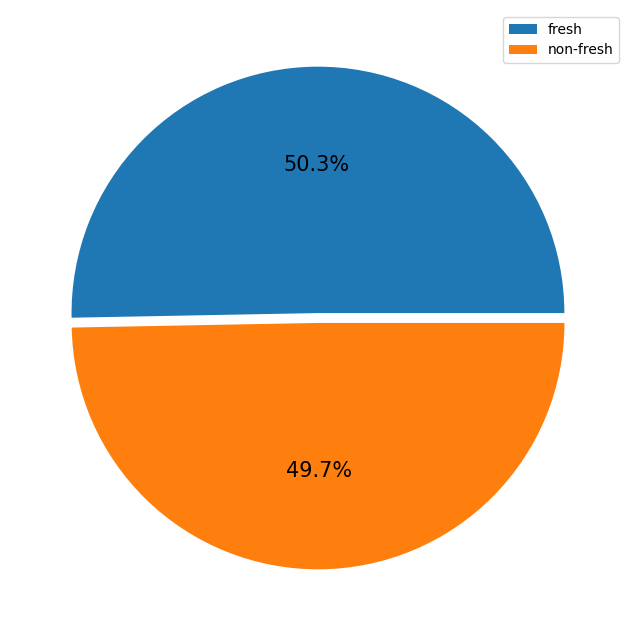

In [ ]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02], textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 224, 224, 3)

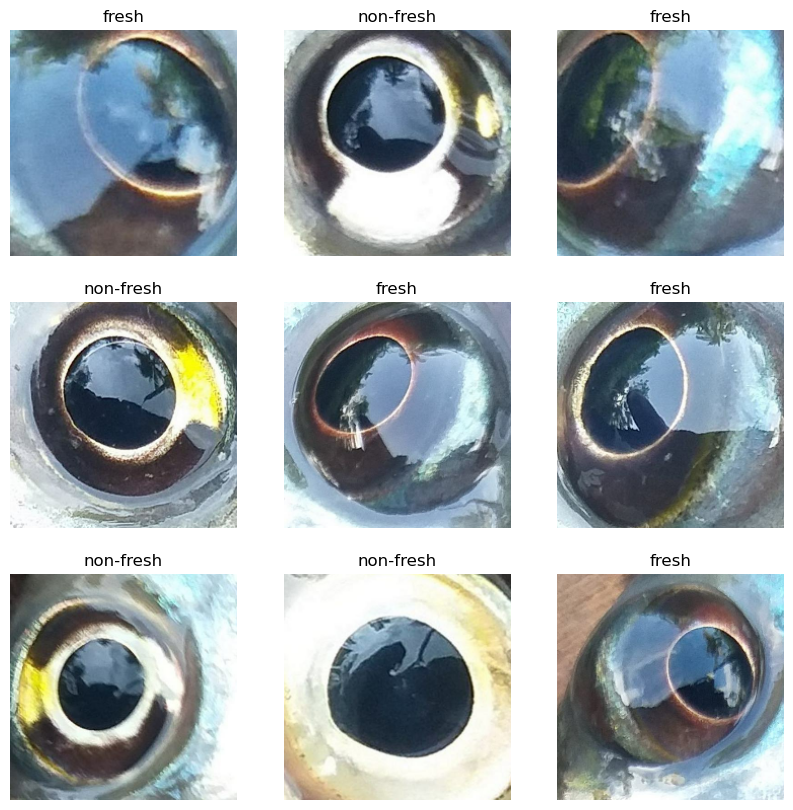

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data = data.map(lambda x, y: (x/255, y))

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


In [ ]:
print("Total number of batchs = ",len(data))

Total number of batchs =  105


In [ ]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 74, # validate batchs = 21, # test batch = 10


105

In [ ]:
test_iter = test.as_numpy_iterator()

In [ ]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [ ]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

In [ ]:
def create_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model = create_baselineCNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

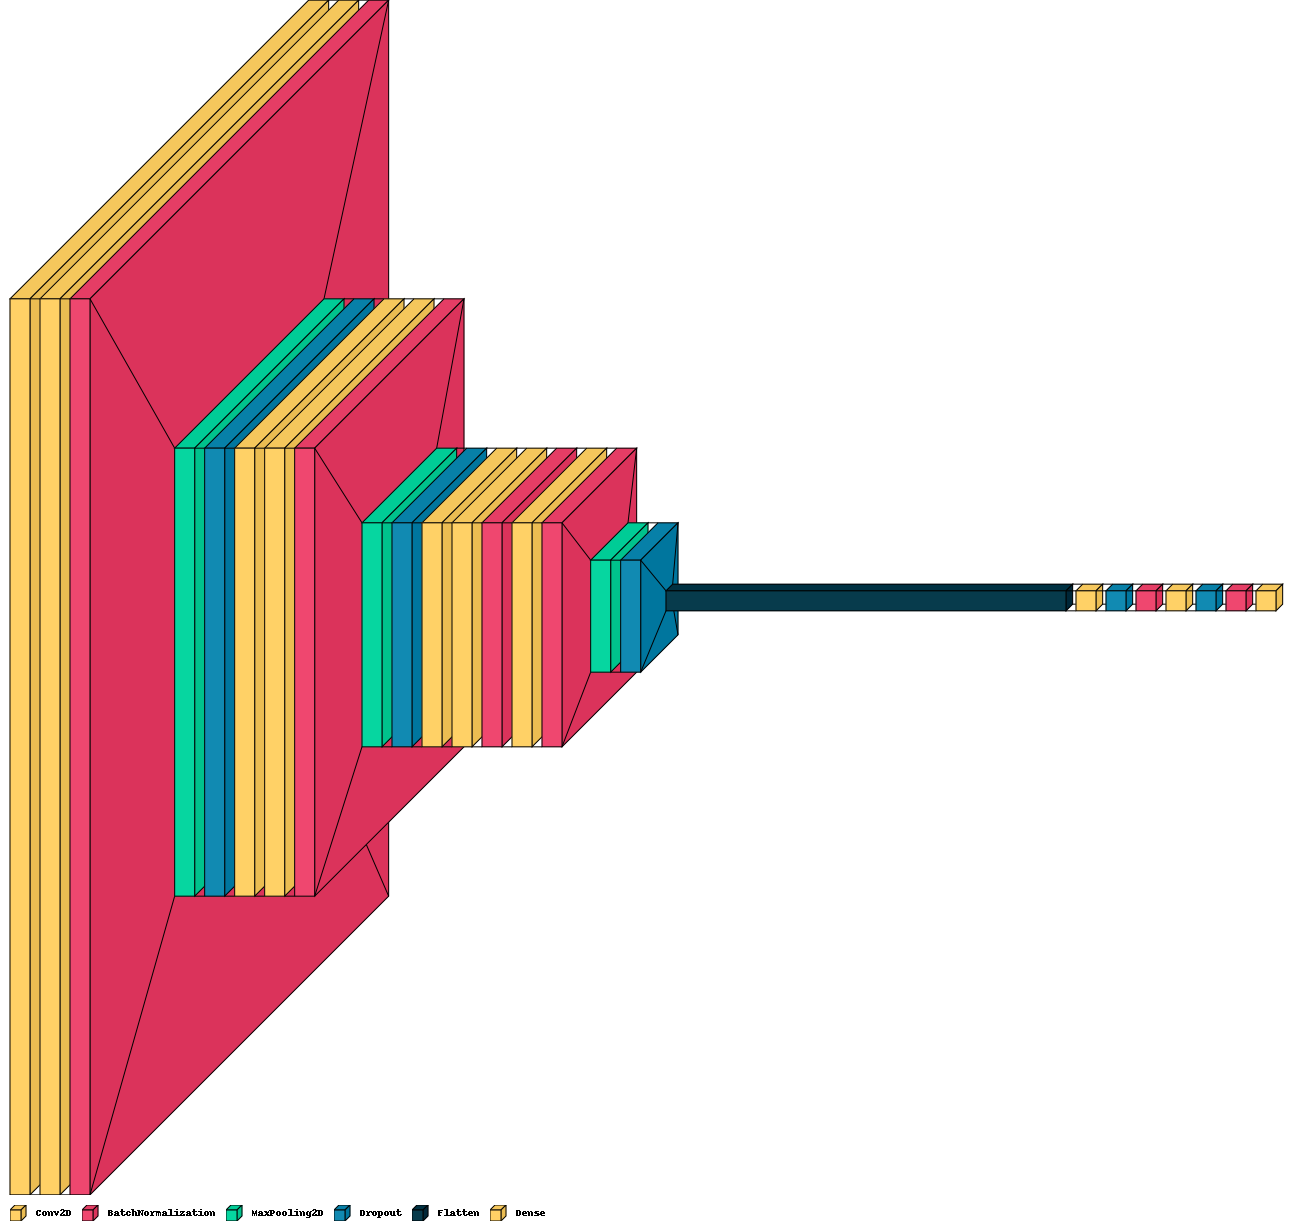

In [ ]:
model.summary()

visualkeras.layered_view(model,legend=True)

In [ ]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 60,
    callbacks=[early_stop],
)

Epoch 1/60


2023-01-09 22:39:53.757161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9745

2023-01-09 22:43:20.814770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 222s 6s/step - loss: 0.0805 - accuracy: 0.9745 - val_loss: 2.1113 - val_accuracy: 0.4969
Epoch 2/60
38/38 [==============================] - 215s 6s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.9832 - val_accuracy: 0.4922
Epoch 3/60
38/38 [==============================] - 219s 6s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 4.5927 - val_accuracy: 0.5016
Epoch 4/60
38/38 [==============================] - 217s 6s/step - loss: 7.8978e-04 - accuracy: 1.0000 - val_loss: 5.0947 - val_accuracy: 0.4859
Epoch 5/60
38/38 [==============================] - 220s 6s/step - loss: 4.8996e-04 - accuracy: 1.0000 - val_loss: 5.1806 - val_accuracy: 0.5141
Epoch 6/60
38/38 [==============================] - 220s 6s/step - loss: 3.2974e-04 - accuracy: 1.0000 - val_loss: 5.3996 - val_accuracy: 0.5266
Epoch 7/60
38/38 [==============================] - 222s 6s/step - loss: 3.4130e-04 - accuracy: 1.0000 - val_loss: 5.6820 - val_accuracy: 0.5141
Epoch 8/

In [ ]:
plot_his(history)

NameError: name 'plot_his' is not defined

In [ ]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

2022-11-22 01:05:54.660135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 364ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

       fresh       0.95      1.00      0.97       138
   non-fresh       1.00      0.94      0.97       130

    accuracy                           0.97       268
   macro avg       0.97      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (2).

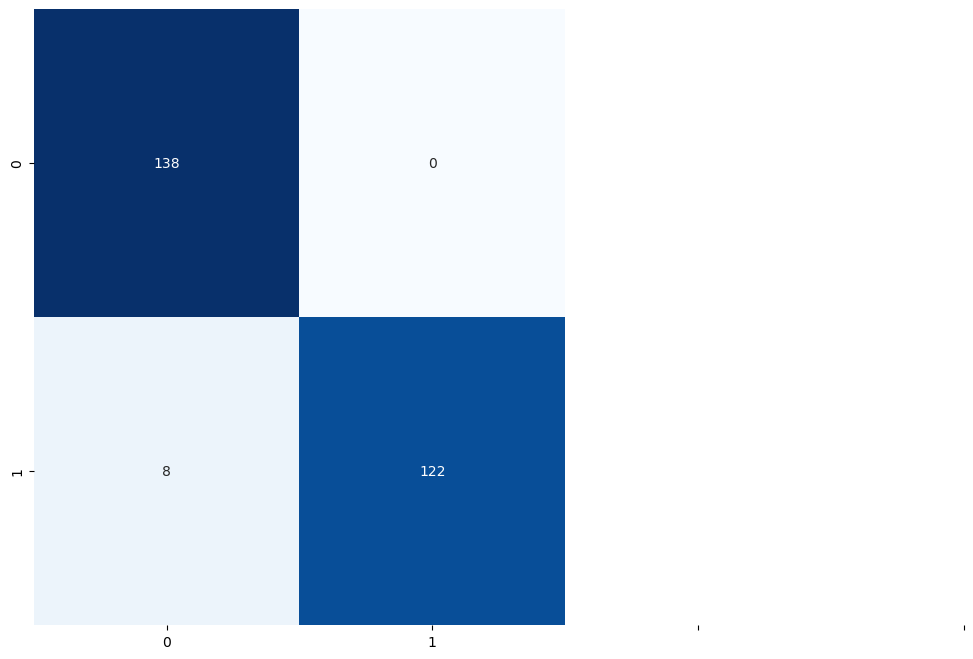

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    effnet.trainable=False
    
    for layer in effnet.layers[83:]:
      layer.trainable=True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(2, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [ ]:
model = make_model()

In [ ]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 60,
    callbacks=[early_stop],
)

Epoch 1/60


InvalidArgumentError: Cannot assign a device for operation model/block3a_se_reduce/Conv2D/ReadVariableOp: Could not satisfy explicit device specification '' because the node {{colocation_node model/block3a_se_reduce/Conv2D/ReadVariableOp}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ResourceApplyAdaMax: CPU 
ReadVariableOp: GPU CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_block3a_se_reduce_conv2d_readvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adamax_adamax_update_resourceapplyadamax_m (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adamax_adamax_update_resourceapplyadamax_v (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model/block3a_se_reduce/Conv2D/ReadVariableOp (ReadVariableOp) 
  Adamax/Adamax/update/ResourceApplyAdaMax (ResourceApplyAdaMax) /job:localhost/replica:0/task:0/device:GPU:0

	 [[{{node model/block3a_se_reduce/Conv2D/ReadVariableOp}}]] [Op:__inference_train_function_28995]

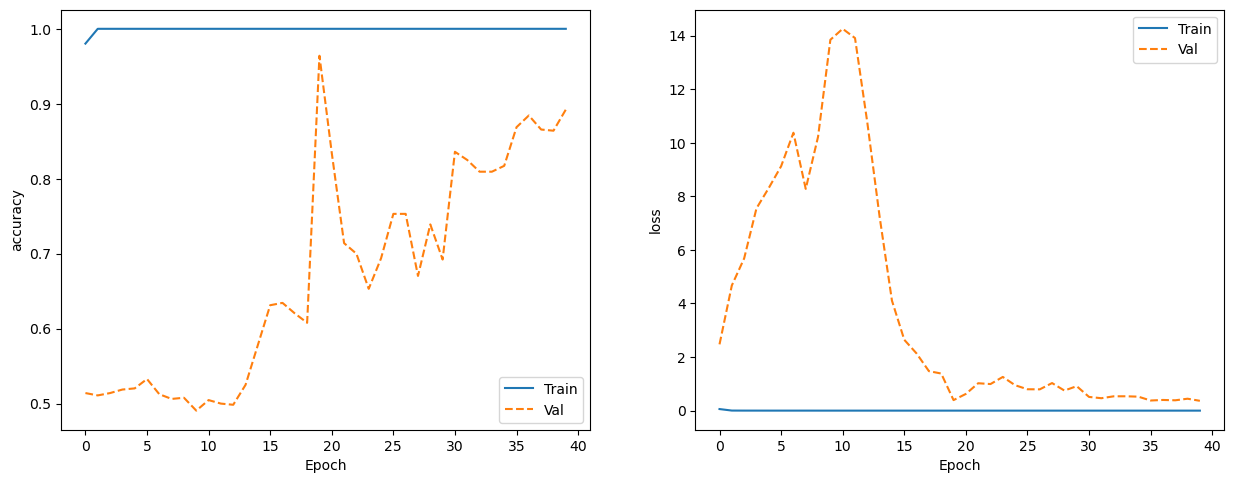

In [ ]:
plot_his(history)

In [ ]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

2022-11-22 01:22:28.127106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 6s 514ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [2]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

NameError: ignored